# 02. Hyperparameter Tuning

Hyperparameters are important because they express "higher-level" structural settings for algorithms. For example, this could be the strength of the penalty used in regularized regression or the number of trees to include in a random forest. **They are decided before fitting a model because they can't be learned from the data.**

### Data Preparation

We begin by loading in the dataset and defining the target and features.

In [55]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, ShuffleSplit, StratifiedShuffleSplit, train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, f1_score

from tqdm import tqdm

In [2]:
run load_data.py

The target feature is the Sale Price and all other features are considered predictor features.

In [3]:
target = train['SalePrice']
features = train.drop(['SalePrice'], axis = 1)

## Cross-Validation

Cross-validation is a method for getting a reliable estimate of model performance using only the training data. We will be looking at the most common one, the 10-fold cross-validation, which breaks the training data into 10 equal folds, essentially creating 10 miniature train/test splits.

These are the models we will be looking at:

In [61]:
models = {
    'Ridge' : Ridge(),
    'Lasso' : Lasso(),
    'KNN' : KNeighborsRegressor(),
    'Decision Tree' : DecisionTreeRegressor(),
    'SVM' : SVR(),
}

Let's try different parameter values and see which is best.

In [114]:
model_params = {
    'Ridge' : {'alpha': range(1,50)},
    'Lasso' : {'alpha' : np.linspace(1,1,20)},
    'KNN' : {'n_neighbors': range(1,20)},
    'Decision Tree' : {'max_depth': range(1,50)},
    'SVM' : {'C': range(1,250,10)},
}

The following creates a function that runs a GridSearchCV on each model.

In [18]:
# Function to run 10 fold Grid Search CV on each model
def run_grid_search(model_name, x_train, x_test, y_train, y_test):
        
    model = models[model_name]
    params = model_params[model_name]
    gs = GridSearchCV(model, param_grid = params, cv = 10, return_train_score = True)
    gs.fit(x_train, y_train)
    
    return {
        'Model Name' : model_name,
        'Best Parameter' : gs.best_params_,
        'Train Score' : gs.best_score_,
        'Test Score' : gs.score(x_test, y_test)
    }

### Results

**Results Before Tuning:**

No. | Model | Train Score | Test Score
--- | --- | --- | ---
0 |	Ridge |	0.949318 |	0.891713
1 |	Lasso |	0.443075 | 	0.442686
2 |	KNN |	0.764370 |	0.639967
3 |	Decision Tree |	1.000000 |	0.682992
4 |	SVR |	0.899767	| 0.868764

**Results After Tuning:**

In [20]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = .25, random_state = 100)

results = []
for model_name in tqdm(models.keys()):
    results.append(run_grid_search(model_name, x_train, x_test, y_train, y_test))

100%|███████████████████████████████████████████| 5/5 [13:34<00:00, 162.83s/it]


In [24]:
results = pd.DataFrame(results)
cols = ['Model Name','Best Parameter', 'Train Score', 'Test Score']
results = results[cols]
results

,Model Name,Best Parameter,Train Score,Test Score
0,Ridge,{'alpha': 6},0.887325,0.894740
1,Lasso,{'alpha': 0.05263157894736842},0.502553,0.517401
2,KNN,{'n_neighbors': 3},0.613381,0.640427
3,Decision Tree,{'max_depth': 6},0.733166,0.757510
4,SVM,{'C': 11},0.875149,0.880576


### Conclusion

After tuning, nearly all the models improved scoring or remained relatively unchanged. Ridge and SVM still seems like the strongest models to use on this dataset, as they consistently generated higher test scores. We have also resolved the issue of overfitting the decision tree model by regulating it with n_neighbors = 3. 

## Complexity Curves

Complexity curves, also known as learning curves, graphs the performance of a model on the training and testing data over a varying number of training instances.This allows us to visual and pinpoint the ideal values that minimize bias and variance.

In [86]:
# Running the Model
def run_model(model, model_name, x_train, x_test, y_train, y_test):
    
    _ = model.fit(x_train, y_train)
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)   
    
    return {
            'Model Name' : model_name,
            'R2 Train Score' : model.score(x_train, y_train),
            'R2 Test Score' : model.score(x_test, y_test)
    } 

In [115]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = .25, random_state = 100)

# Models we will be working with
models = {
    'Ridge' : Ridge,
    'Lasso' : Lasso,
    'KNN' : KNeighborsRegressor,
    'Decision Tree' : DecisionTreeRegressor,
    'SVM' : SVR
}

# Testing different hyperparameter values
curve_results = {}
for model_name in tqdm(models.keys()):    
    curve_results[model_name] = []
    model = models[model_name]
    argument = list(model_params[model_name].keys())[0]
    
    for value in model_params[model_name][argument]:
        params = {argument : value}
        curve_results[model_name].append(run_model(model(**params), model_name, x_train, x_test, y_train, y_test))

100%|████████████████████████████████████████████| 5/5 [02:45<00:00, 33.09s/it]


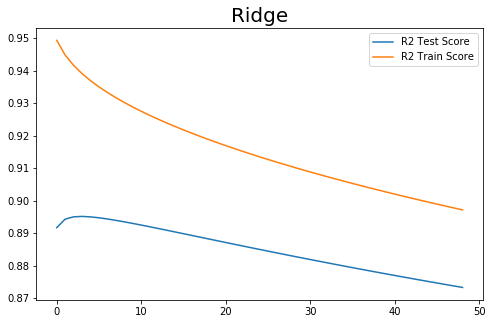

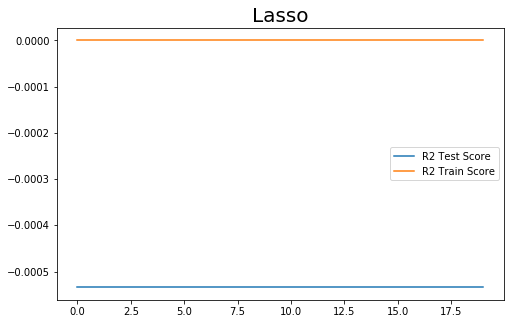

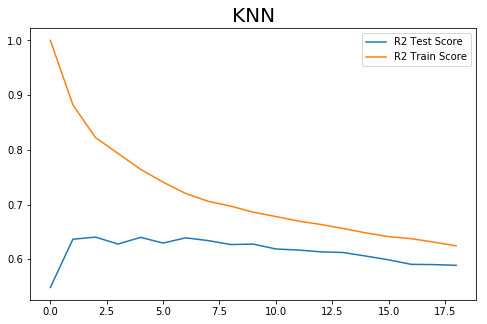

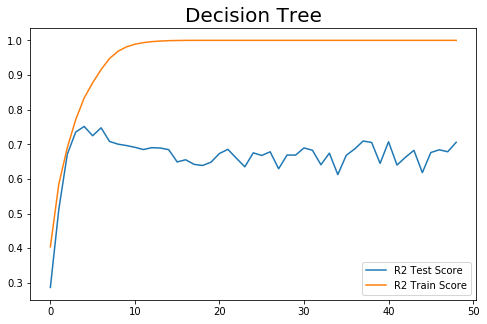

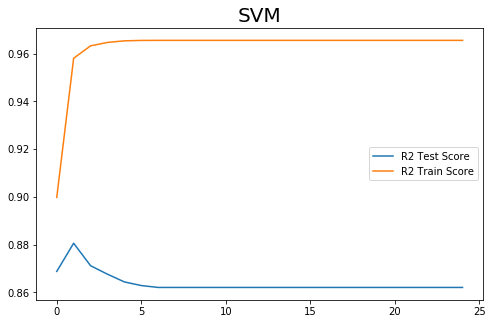

In [116]:
# Plot the curves
for model in curve_results:
    model_df = pd.DataFrame(curve_results[model])
    plt.figure(figsize=(8,5)) 
    plt.title(model, fontsize = 20)
    plt.plot(range(len(model_df)), model_df['R2 Test Score'], label='R2 Test Score')
    plt.plot(range(len(model_df)), model_df['R2 Train Score'], label='R2 Train Score')
    plt.legend()